Ref: https://www.kaggle.com/code/ritvik1909/speech-classification-spectrogram-cnn

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import math

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
import IPython.display
from tqdm import tqdm
import librosa
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [4]:
sample_path = 'MLEndLS/*.wav'
files = glob.glob(sample_path)
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 

In [39]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['in_out', 'area']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

input_data = column_transformer.fit_transform(MLENDLS_df)
input_data = pd.DataFrame(data=input_data, index=MLENDLS_df.index, columns=column_transformer.get_feature_names_out())

labels = MLENDLS_df['spot'].to_numpy()

input_data = input_data.drop(columns=[
    'Participant',
    'spot'
])

# display(input_data)
# display(labels)

[[0.0 1.0 0.0 ... 0.0 'street' 'S151']
 [1.0 0.0 0.0 ... 0.0 'dinosaur' 'S127']
 [0.0 1.0 0.0 ... 0.0 'square' 'S18']
 ...
 [1.0 0.0 0.0 ... 1.0 'national' 'S96']
 [1.0 0.0 0.0 ... 0.0 'room12' 'S73']
 [1.0 0.0 0.0 ... 0.0 'room12' 'S58']]
         in_out_indoor in_out_outdoor area_Euston area_british area_campus  \
file_id                                                                      
0001.wav           0.0            1.0         0.0          1.0         0.0   
0002.wav           1.0            0.0         0.0          0.0         0.0   
0003.wav           0.0            1.0         0.0          0.0         1.0   
0004.wav           1.0            0.0         0.0          0.0         0.0   
0005.wav           0.0            1.0         0.0          0.0         1.0   
...                ...            ...         ...          ...         ...   
2496.wav           0.0            1.0         0.0          0.0         0.0   
2497.wav           0.0            1.0         0.0         

In [65]:
aud_data = []
labels = []
meta_data = []

for n in range(0,int(len(files))):
    a, fs = librosa.load(files[n],sr=None)
    
    # FFT Frequency extraction
    data = librosa.feature.chroma_stft(y=a)
    
    # Trimming to get a standard input size
    data = data[:,:536].T
    data = data.reshape(1,data.shape[0]*data.shape[1])
    data = data[0]
    
    # Filtering errored/invalid/short data
    if len(data) < 536*12: continue
    if (n%100 == 0): print(n, end="\r")
        
    aud_data.append(data)
    meta_data.append(input_data.loc[files[n].split('/')[-1]].to_numpy())
    labels.append(MLENDLS_df.loc[files[n].split('/')[-1]]['spot'])
    
print("\nDone")

/home/samsepiol/pyenvs/ml/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


2400
Done


In [58]:
import pandas as pd
from sklearn.decomposition import PCA

# After various attempts, it was observed that we get the best results with atleast 5 components
numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(aud_data)

projected = pca.transform(aud_data)

# Add the hot encoded category features to the input
projected = np.concatenate((projected, meta_data), axis=1)

projected = pd.DataFrame(projected,columns=[
        'pc1',
        'pc2', 
        'in_out_indoor', 
        'in_out_outdoor', 
        'area_Euston', 
        'area_british', 
        'area_campus',
        'area_kensington', 
        'area_southbank', 
        'area_westend' 
])

print(projected)

          pc1       pc2 in_out_indoor in_out_outdoor area_Euston area_british  \
0   -8.372871 -6.579957           0.0            1.0         0.0          0.0   
1    6.731894  -2.60293           1.0            0.0         0.0          0.0   
2    2.251407 -1.836723           1.0            0.0         0.0          0.0   
3   -2.237509  5.105683           0.0            1.0         0.0          0.0   
4    -8.84454 -3.567096           0.0            1.0         0.0          0.0   
..        ...       ...           ...            ...         ...          ...   
243 -8.909318 -2.446361           0.0            1.0         0.0          1.0   
244  4.971639  2.017177           0.0            1.0         0.0          0.0   
245 -6.756484 -1.019082           0.0            1.0         0.0          1.0   
246 -9.570527 -0.356729           0.0            1.0         0.0          0.0   
247 -0.199921  -1.74097           1.0            0.0         0.0          0.0   

    area_campus area_kensin

from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_val, y_train, y_val = train_test_split(projected,labels,test_size=0.2)
print(X_train.shape, X_val.shape)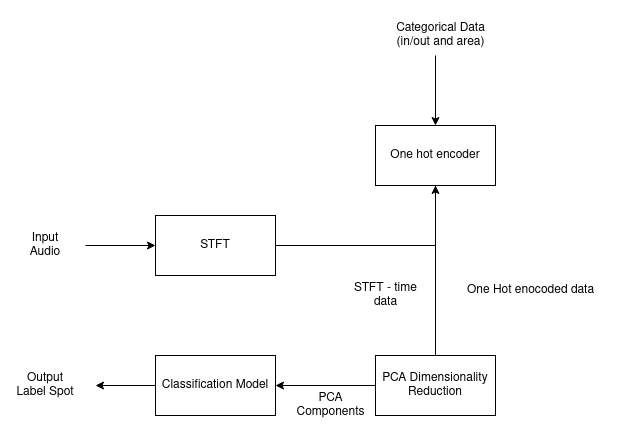

In [64]:
from sklearn import svm

parameters = {'C':[1,10,20,50]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters,cv=5)

clf.fit(X_train,y_train)

print('Hyperparameters: ', clf.best_estimator_)
print('Average accuracy: ', clf.best_score_)
print('Test dataset accuracy:', clf.score(X_val, y_val))

Hyperparameters:  SVC(C=20)
Average accuracy:  0.418974358974359
Test dataset accuracy: 0.28


/home/samsepiol/pyenvs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# 8 Results

Carry out your experiments here, explain your results.

  
  
--------------------------------------
--------------------------------------
--------------------------------------
  
  
  

# 9 Conclusions

Your conclusions, improvements, etc should go here